In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import gc

### loading the dataset as a tf.data.dataset object

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'C:\Users\VICTUS\Desktop\pattern project\RealWaste',
    batch_size=32,
    image_size=(256,256),     #resizing
    shuffle=True,
    seed=123
) 

Found 4752 files belonging to 9 classes.


In [3]:
dataset.class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

(32, 256, 256, 3)
(32,)


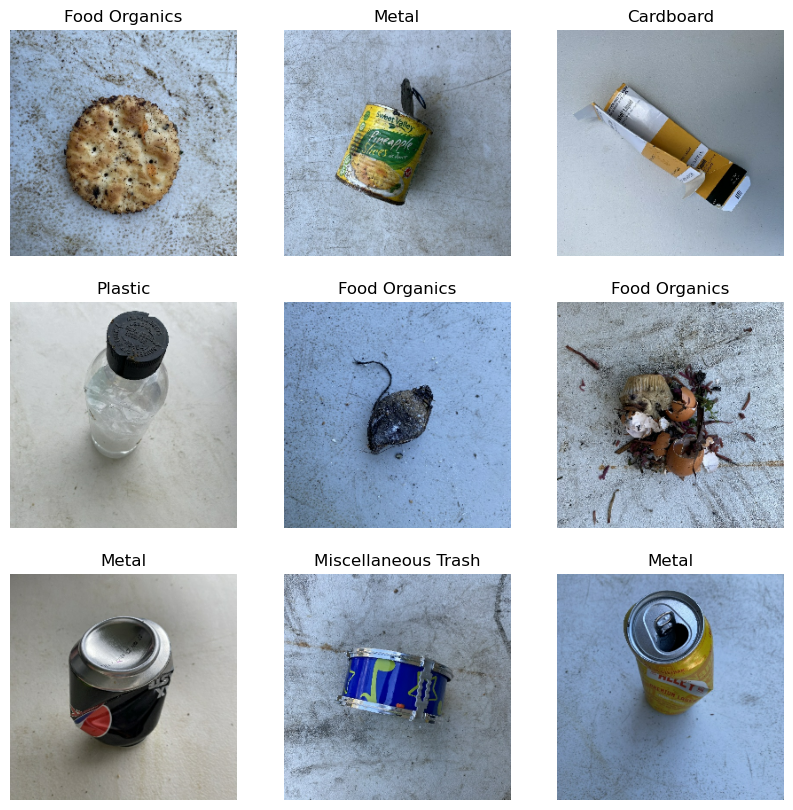

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):

  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[i]])
    plt.axis("off")

In [5]:
len(dataset)

149

In [6]:
train_dataset=dataset.take(105)
remaining=dataset.skip(105)

print(f"Percentage of traning set {round(((len(train_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(remaining)/len(dataset))*100))} %")


Percentage of traning set 70 %
Percentage of test set 30 %


In [7]:
test_dataset=remaining.take(22)
cv_dataset=remaining.skip(22)
print(f"Percentage of traning set {round(((len(test_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(cv_dataset)/len(dataset))*100))} %")

Percentage of traning set 15 %
Percentage of test set 15 %


In [43]:
test_dataset.save('saved_datasets/test_dataset')
train_dataset.save('saved_datasets/train_dataset')
cv_dataset.save('saved_datasets/cv_dataset')

In [44]:
train_dataset = tf.data.Dataset.load('saved_datasets/train_dataset')
cv_dataset = tf.data.Dataset.load('saved_datasets/cv_dataset')
test_dataset = tf.data.Dataset.load('saved_datasets/test_dataset')

In [8]:
def class_counts(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, labels in dataset.unbatch():      # unbatch = go sample-by-sample
        if len(labels.shape) == 0:           
            counts[labels.numpy()] += 1
        else:                                # one-hot labels
            counts[np.argmax(labels.numpy())] += 1
    return counts

In [9]:
#dataset_counts = class_counts(dataset, 9)
#dataset_counts

In [10]:
#train_counts = class_counts(train_dataset, 9)
#train_counts

In [11]:
#test_counts = class_counts(test_dataset, 9)
#test_counts

In [12]:
#cv_counts = class_counts(cv_dataset, 9)
#cv_counts

In [34]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)


In [41]:
from keras import layers
model = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    Dropout(0.3),
    
    layers.Dense(9, activation='softmax'),
])

In [37]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop] 
)

Epoch 1/20


105/105 [==============================] - 65s 533ms/step - loss: 2.0909 - accuracy: 0.2414 - val_loss: 1.8612 - val_accuracy: 0.2965 - lr: 0.0010
Epoch 2/20
105/105 [==============================] - 51s 481ms/step - loss: 1.8016 - accuracy: 0.3411 - val_loss: 1.6293 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 3/20
105/105 [==============================] - 62s 592ms/step - loss: 1.6704 - accuracy: 0.4015 - val_loss: 1.4857 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 4/20
105/105 [==============================] - 51s 486ms/step - loss: 1.5813 - accuracy: 0.4405 - val_loss: 1.4704 - val_accuracy: 0.4927 - lr: 0.0010
Epoch 5/20
105/105 [==============================] - 44s 420ms/step - loss: 1.4866 - accuracy: 0.4717 - val_loss: 1.4363 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 6/20
105/105 [==============================] - 51s 484ms/step - loss: 1.4711 - accuracy: 0.4836 - val_loss: 1.4034 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 7/20
105/105 [==============================] - 53s 507ms

In [39]:
scores=model.evaluate(test_dataset)

22/22 [==============================] - 3s 29ms/step - loss: 0.9590 - accuracy: 0.6321


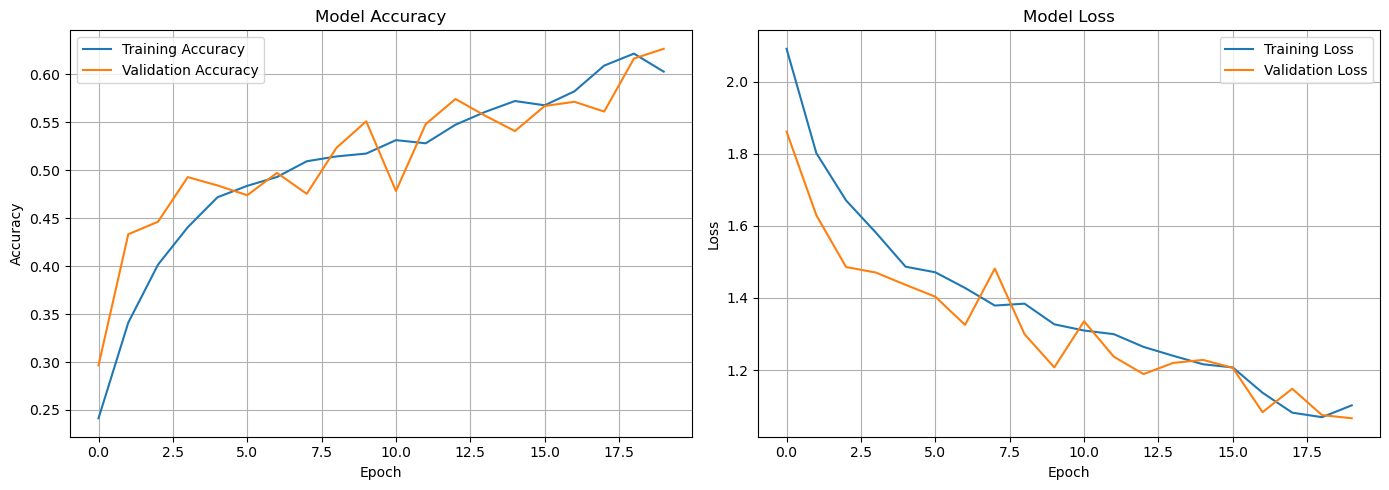


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.6027
Final Validation Accuracy: 0.6265
Final Training Loss: 1.1020
Final Validation Loss: 1.0663
--------------------------------------------------


In [40]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)